In [1]:
import pandas as pd
import os

In [2]:
import librosa

C:\Users\a-ber\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:

Tess = r"D:\Program Files\Videola\Bilgisayar Mühendisliği\CENG407\Labellenmis"

In [4]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + '\\' + dir )
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[1]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + '/' + dir  + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df)

     Emotions                                               Path
0       angry  D:\Program Files\Videola\Bilgisayar Mühendisli...
1       angry  D:\Program Files\Videola\Bilgisayar Mühendisli...
2       angry  D:\Program Files\Videola\Bilgisayar Mühendisli...
3       angry  D:\Program Files\Videola\Bilgisayar Mühendisli...
4       angry  D:\Program Files\Videola\Bilgisayar Mühendisli...
...       ...                                                ...
7375      sad  D:\Program Files\Videola\Bilgisayar Mühendisli...
7376      sad  D:\Program Files\Videola\Bilgisayar Mühendisli...
7377      sad  D:\Program Files\Videola\Bilgisayar Mühendisli...
7378      sad  D:\Program Files\Videola\Bilgisayar Mühendisli...
7379      sad  D:\Program Files\Videola\Bilgisayar Mühendisli...

[7380 rows x 2 columns]


In [5]:
Tess_df['Emotions'].value_counts()

frustration    1849
neutral        1708
angry          1103
sad            1084
excited        1041
happy           595
Name: Emotions, dtype: int64

In [6]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [7]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(Tess_df.iterrows()):
    file_name = os.path.join(os.path.abspath(Tess),str(row["Path"]))
    final_class_labels=row["Emotions"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

7380it [04:29, 27.40it/s]


In [8]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['Path','Emotions'])
extracted_features_df.head()
# Storing the dataframe to pickle for further processing
extracted_features_df.to_pickle("extracted_df.pkl")
extracted_features_df.head()

,Path,Emotions
0,"[-322.04932, 136.34343, -30.183025, 23.66656, ...",angry
1,"[-289.68463, 122.64088, -20.96545, 35.34087, -...",angry
2,"[-199.22662, 127.5769, -54.481873, 17.674515, ...",angry
3,"[-394.34372, 142.89366, -31.46713, 46.804314, ...",angry
4,"[-391.47177, 124.91465, -24.61907, 23.692755, ...",angry


In [9]:
final = pd.read_pickle("./extracted_df.pkl")
X = np.array(final["Path"].tolist())
y = np.array(final["Emotions"].tolist())

In [10]:
        import IPython.display as ipd
        import librosa
        import librosa.display
        import pandas as pd
        import os, time, warnings
        import seaborn as sns
        import numpy as np
        from tqdm import tqdm
        import matplotlib.pyplot as plt
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import LabelEncoder
        from tensorflow.keras.utils import to_categorical
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import (
            Dense,
            Conv1D,
            MaxPooling1D,
            BatchNormalization,
            Dropout, 
            Flatten,
            Conv2D,
            MaxPool2D,
        )

In [11]:
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42
)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])


Number of training samples =  6642
Number of testing samples =  738


In [43]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback
import numpy as np

# Model fonksiyonu oluştur
def create_model(learning_rate=0.001, optimizer='adam', activation='relu', batch_size=32, epochs=100):
    num_labels = Y.shape[1]
    model = Sequential()
    model.add(Dense(1000, activation=activation, input_shape=(40,)))
    model.add(Dense(750, activation=activation))
    model.add(Dense(500, activation=activation))
    model.add(Dense(250, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(50, activation=activation))
    model.add(Dense(num_labels, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

# Geri çağırma fonksiyonu (Callback function) oluştur
class TestParamCallback(Callback):
    def __init__(self, params):
        super(TestParamCallback, self).__init__()
        self.params = params
    
    def on_train_begin(self, logs=None):
        print("Test edilen parametreler:")
        for key, value in self.params.items():
            print(key + ':', value)
    
    def on_epoch_begin(self, epoch, logs=None):
        print("Epoch:", epoch+1)

# Keras sınıflandırıcıyı oluştur
model = KerasClassifier(build_fn=create_model)

from sklearn.model_selection import ParameterGrid

# Optimizasyon için parametrelerin listesi
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'sigmoid'],
    'batch_size': [16, 32, 64],
    'epochs': [10]
}

# Tüm hiperparametre kombinasyonlarını elde et
param_combinations = ParameterGrid(param_grid)

# Denenen her adımda parametreleri görüntülemek için döngü
for params in param_combinations:
    print("Test edilen parametreler:")
    for key, value in params.items():
        print(key + ':', value)
    
    # Modeli oluştur
    model = create_model(
        learning_rate=params['learning_rate'],
        optimizer=params['optimizer'],
        activation=params['activation'],
        batch_size=params['batch_size'],
        epochs=params['epochs']
    )
    
    # Modeli eğit
    history = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=(X_test, y_test))
    
    # Test sonuçlarını görüntüle
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test kaybı: ", test_loss)
    print("Test doğruluk değeri: ", test_accuracy)
    print()




C:\Users\a-ber\AppData\Local\Temp\ipykernel_11956\3025428724.py:39: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Test edilen parametreler:
activation: relu
batch_size: 16
epochs: 10
learning_rate: 0.001
optimizer: adam
Epoch 1/10
416/416 [==============================] - 5s 11ms/step - loss: 2.0835 - accuracy: 0.3109 - val_loss: 1.5960 - val_accuracy: 0.3659
Epoch 2/10
416/416 [==============================] - 4s 10ms/step - loss: 1.5451 - accuracy: 0.3615 - val_loss: 1.5376 - val_accuracy: 0.3808
Epoch 3/10
416/416 [==============================] - 4s 10ms/step - loss: 1.5007 - accuracy: 0.3812 - val_loss: 1.5171 - val_accuracy: 0.3889
Epoch 4/10
416/416 [==============================] - 5s 11ms/step - loss: 1.4882 - accuracy: 0.3908 - val_loss: 1.5993 - val_accuracy: 0.3266
Epoch 5/10
416/416 [==============================] - 4s 10ms/step - loss: 1.4748 - accuracy: 0.3924 - val_loss: 1.4964 - val_accuracy: 0.3808
Epoch 6/10
416/416 [==============================] - 4s 10ms/step - loss: 1.4550 - accuracy: 0.4036 - val_loss: 1.4910 - val_accuracy: 0.3943
Epoch 7/10
416/416 [================

Epoch 10/10
24/24 [==============================] - 0s 7ms/step - loss: 1.7682 - accuracy: 0.2100
Test kaybı:  1.7681958675384521
Test doğruluk değeri:  0.21002709865570068

Test edilen parametreler:
activation: relu
batch_size: 16
epochs: 10
learning_rate: 0.1
optimizer: rmsprop
Epoch 1/10
416/416 [==============================] - 10s 21ms/step - loss: 69847280.0000 - accuracy: 0.2368 - val_loss: 1.7482 - val_accuracy: 0.2588
Epoch 2/10
416/416 [==============================] - 8s 19ms/step - loss: 1.7447 - accuracy: 0.2404 - val_loss: 1.7498 - val_accuracy: 0.2588
Epoch 3/10
416/416 [==============================] - 7s 18ms/step - loss: 1.7438 - accuracy: 0.2478 - val_loss: 1.7605 - val_accuracy: 0.2100
Epoch 4/10
416/416 [==============================] - 7s 17ms/step - loss: 1.7463 - accuracy: 0.2397 - val_loss: 1.7767 - val_accuracy: 0.2588
Epoch 5/10
416/416 [==============================] - 7s 17ms/step - loss: 1.7443 - accuracy: 0.2427 - val_loss: 1.7604 - val_accuracy: 0.

Epoch 8/10
208/208 [==============================] - 5s 23ms/step - loss: 1.5746 - accuracy: 0.3350 - val_loss: 1.6300 - val_accuracy: 0.3062
Epoch 9/10
208/208 [==============================] - 5s 23ms/step - loss: 1.5642 - accuracy: 0.3389 - val_loss: 1.7247 - val_accuracy: 0.2913
Epoch 10/10
24/24 [==============================] - 0s 6ms/step - loss: 1.5958 - accuracy: 0.3428
Test kaybı:  1.5957502126693726
Test doğruluk değeri:  0.3428184390068054

Test edilen parametreler:
activation: relu
batch_size: 32
epochs: 10
learning_rate: 0.1
optimizer: adam
Epoch 1/10
208/208 [==============================] - 5s 19ms/step - loss: 129916.3594 - accuracy: 0.2293 - val_loss: 1.7412 - val_accuracy: 0.2100
Epoch 2/10
208/208 [==============================] - 3s 14ms/step - loss: 1.7355 - accuracy: 0.2371 - val_loss: 1.7399 - val_accuracy: 0.2100
Epoch 3/10
208/208 [==============================] - 3s 15ms/step - loss: 1.7357 - accuracy: 0.2404 - val_loss: 1.7411 - val_accuracy: 0.2588
Ep

Epoch 6/10
104/104 [==============================] - 2s 16ms/step - loss: 1.5163 - accuracy: 0.3767 - val_loss: 1.5319 - val_accuracy: 0.3659
Epoch 7/10
104/104 [==============================] - 2s 17ms/step - loss: 1.5013 - accuracy: 0.3823 - val_loss: 1.5620 - val_accuracy: 0.3415
Epoch 8/10
104/104 [==============================] - 2s 17ms/step - loss: 1.4847 - accuracy: 0.3883 - val_loss: 1.4959 - val_accuracy: 0.3889
Epoch 9/10
104/104 [==============================] - 2s 17ms/step - loss: 1.4861 - accuracy: 0.3957 - val_loss: 1.5438 - val_accuracy: 0.3509
Epoch 10/10
24/24 [==============================] - 0s 5ms/step - loss: 1.5213 - accuracy: 0.3984
Test kaybı:  1.5212968587875366
Test doğruluk değeri:  0.3983739912509918

Test edilen parametreler:
activation: relu
batch_size: 64
epochs: 10
learning_rate: 0.01
optimizer: rmsprop
Epoch 1/10
104/104 [==============================] - 3s 22ms/step - loss: 151.2227 - accuracy: 0.2249 - val_loss: 1.7542 - val_accuracy: 0.2114
E

Epoch 4/10
416/416 [==============================] - 9s 21ms/step - loss: 1.5407 - accuracy: 0.3615 - val_loss: 1.5941 - val_accuracy: 0.3225
Epoch 5/10
416/416 [==============================] - 8s 18ms/step - loss: 1.5349 - accuracy: 0.3740 - val_loss: 1.7861 - val_accuracy: 0.2507
Epoch 6/10
416/416 [==============================] - 8s 20ms/step - loss: 1.5285 - accuracy: 0.3731 - val_loss: 1.5753 - val_accuracy: 0.3631
Epoch 7/10
416/416 [==============================] - 8s 20ms/step - loss: 1.5262 - accuracy: 0.3648 - val_loss: 1.5615 - val_accuracy: 0.3360
Epoch 8/10
416/416 [==============================] - 9s 22ms/step - loss: 1.5167 - accuracy: 0.3750 - val_loss: 1.5747 - val_accuracy: 0.3455
Epoch 9/10
416/416 [==============================] - 8s 20ms/step - loss: 1.5171 - accuracy: 0.3711 - val_loss: 1.5321 - val_accuracy: 0.3645
Epoch 10/10
24/24 [==============================] - 0s 5ms/step - loss: 1.5940 - accuracy: 0.3306
Test kaybı:  1.5939737558364868
Test doğrul

Epoch 2/10
208/208 [==============================] - 3s 17ms/step - loss: 1.6044 - accuracy: 0.3217 - val_loss: 1.5933 - val_accuracy: 0.3238
Epoch 3/10
208/208 [==============================] - 3s 15ms/step - loss: 1.5695 - accuracy: 0.3421 - val_loss: 1.5957 - val_accuracy: 0.3360
Epoch 4/10
208/208 [==============================] - 3s 16ms/step - loss: 1.5633 - accuracy: 0.3457 - val_loss: 1.5928 - val_accuracy: 0.3347
Epoch 5/10
208/208 [==============================] - 3s 16ms/step - loss: 1.5477 - accuracy: 0.3601 - val_loss: 1.5527 - val_accuracy: 0.3604
Epoch 6/10
208/208 [==============================] - 3s 16ms/step - loss: 1.5302 - accuracy: 0.3586 - val_loss: 1.5403 - val_accuracy: 0.3591
Epoch 7/10
208/208 [==============================] - 3s 16ms/step - loss: 1.5280 - accuracy: 0.3595 - val_loss: 1.5990 - val_accuracy: 0.3306
Epoch 8/10
208/208 [==============================] - 4s 18ms/step - loss: 1.5141 - accuracy: 0.3737 - val_loss: 1.5529 - val_accuracy: 0.3645

Epoch 1/10
208/208 [==============================] - 6s 24ms/step - loss: 2.5110 - accuracy: 0.1948 - val_loss: 2.2722 - val_accuracy: 0.2588
Epoch 2/10
208/208 [==============================] - 4s 21ms/step - loss: 2.0297 - accuracy: 0.2066 - val_loss: 1.8576 - val_accuracy: 0.2588
Epoch 3/10
208/208 [==============================] - 4s 21ms/step - loss: 2.0266 - accuracy: 0.2045 - val_loss: 2.4534 - val_accuracy: 0.1463
Epoch 4/10
208/208 [==============================] - 4s 22ms/step - loss: 2.0439 - accuracy: 0.1980 - val_loss: 2.0917 - val_accuracy: 0.1572
Epoch 5/10
208/208 [==============================] - 4s 21ms/step - loss: 2.0341 - accuracy: 0.2094 - val_loss: 2.4106 - val_accuracy: 0.1572
Epoch 6/10
208/208 [==============================] - 4s 20ms/step - loss: 2.0350 - accuracy: 0.2007 - val_loss: 2.3092 - val_accuracy: 0.0759
Epoch 7/10
208/208 [==============================] - 5s 24ms/step - loss: 2.0269 - accuracy: 0.2109 - val_loss: 2.2651 - val_accuracy: 0.2588

24/24 [==============================] - 0s 5ms/step - loss: 1.7551 - accuracy: 0.2100
Test kaybı:  1.755130648612976
Test doğruluk değeri:  0.21002709865570068

Test edilen parametreler:
activation: sigmoid
batch_size: 64
epochs: 10
learning_rate: 0.1
optimizer: adam
Epoch 1/10
104/104 [==============================] - 3s 22ms/step - loss: 1.9826 - accuracy: 0.2004 - val_loss: 1.8245 - val_accuracy: 0.1572
Epoch 2/10
104/104 [==============================] - 2s 19ms/step - loss: 1.8058 - accuracy: 0.2159 - val_loss: 1.8877 - val_accuracy: 0.2100
Epoch 3/10
104/104 [==============================] - 2s 17ms/step - loss: 1.8086 - accuracy: 0.2243 - val_loss: 1.8637 - val_accuracy: 0.2100
Epoch 4/10
104/104 [==============================] - 2s 18ms/step - loss: 1.8138 - accuracy: 0.2201 - val_loss: 1.7603 - val_accuracy: 0.2588
Epoch 5/10
104/104 [==============================] - 2s 16ms/step - loss: 1.7977 - accuracy: 0.2276 - val_loss: 1.8310 - val_accuracy: 0.2588
Epoch 6/10
104/1

In [53]:
from keras.optimizers import RMSprop

num_labels = Y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(40,)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))
ANN_Model.summary()

optimizer = Adam(learning_rate=0.0001)
ANN_Model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)


Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1180 (Dense)          (None, 1000)              41000     
                                                                 
 dense_1181 (Dense)          (None, 750)               750750    
                                                                 
 dense_1182 (Dense)          (None, 500)               375500    
                                                                 
 dense_1183 (Dense)          (None, 250)               125250    
                                                                 
 dense_1184 (Dense)          (None, 100)               25100     
                                                                 
 dense_1185 (Dense)          (None, 50)                5050      
                                                                 
 dense_1186 (Dense)          (None, 6)              

In [54]:
ANN_Model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)


In [66]:
num_epochs = 30
num_batch_size = 64

t0 = time.time()

history = ANN_Model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
)

ANN_Model.save("Model1.h5")
print("ANN Model Saved")


Epoch 1/30
104/104 [==============================] - 2s 20ms/step - loss: 1.3403 - accuracy: 0.4613 - val_loss: 1.4327 - val_accuracy: 0.4119
Epoch 2/30
104/104 [==============================] - 2s 19ms/step - loss: 1.3228 - accuracy: 0.4697 - val_loss: 1.4493 - val_accuracy: 0.4011
Epoch 3/30
104/104 [==============================] - 2s 19ms/step - loss: 1.3123 - accuracy: 0.4678 - val_loss: 1.4182 - val_accuracy: 0.4350
Epoch 4/30
104/104 [==============================] - 2s 21ms/step - loss: 1.3147 - accuracy: 0.4752 - val_loss: 1.4364 - val_accuracy: 0.4065
Epoch 5/30
104/104 [==============================] - 2s 20ms/step - loss: 1.3164 - accuracy: 0.4711 - val_loss: 1.4528 - val_accuracy: 0.4092
Epoch 6/30
104/104 [==============================] - 2s 20ms/step - loss: 1.3034 - accuracy: 0.4744 - val_loss: 1.4128 - val_accuracy: 0.4377
Epoch 7/30
104/104 [==============================] - 2s 17ms/step - loss: 1.3005 - accuracy: 0.4771 - val_loss: 1.4329 - val_accuracy: 0.4282

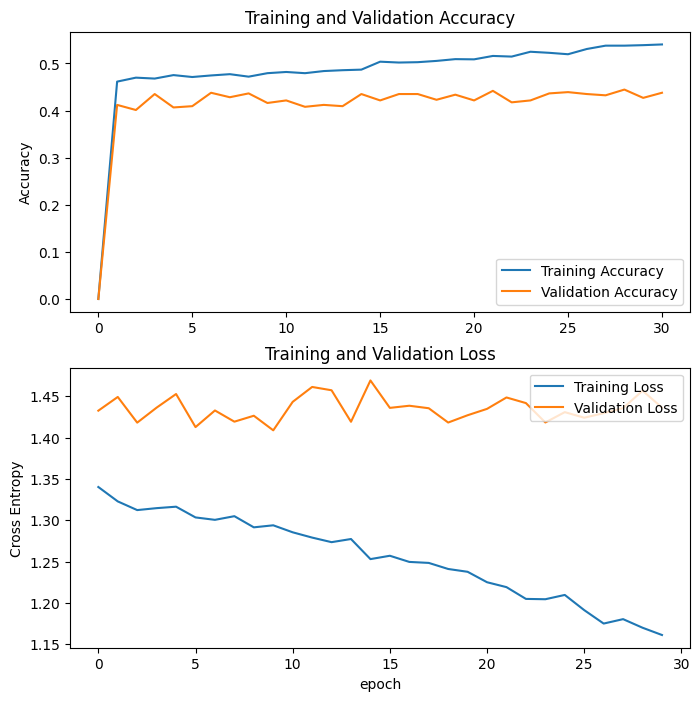

In [67]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [68]:
emotion_names=extracted_features_df['Emotions'].unique()


In [69]:
y_pred = ANN_Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

24/24 [==============================] - 0s 8ms/step


array([3, 1, 5, 2, 1, 2, 4, 2, 2, 3, 0, 1, 5, 2, 4, 4, 1, 4, 2, 3, 4, 2,
       0, 5, 2, 1, 5, 5, 0, 0, 1, 3, 5, 4, 2, 4, 4, 5, 1, 4, 0, 2, 5, 2,
       4, 4, 0, 2, 5, 1, 5, 5, 5, 2, 5, 5, 2, 5, 5, 4, 1, 2, 4, 2, 4, 1,
       1, 4, 1, 0, 2, 4, 2, 2, 2, 4, 4, 4, 0, 2, 4, 0, 2, 1, 0, 5, 5, 2,
       5, 2, 2, 4, 2, 4, 2, 2, 1, 5, 2, 0, 4, 1, 4, 0, 0, 2, 4, 5, 4, 4,
       4, 0, 2, 1, 0, 2, 3, 4, 5, 1, 2, 5, 2, 0, 5, 4, 4, 2, 5, 2, 4, 2,
       2, 2, 1, 2, 1, 0, 2, 4, 4, 5, 2, 0, 5, 4, 4, 1, 2, 4, 5, 2, 2, 1,
       5, 4, 5, 5, 0, 4, 1, 1, 4, 0, 4, 4, 4, 1, 2, 1, 5, 2, 2, 4, 5, 0,
       1, 5, 5, 5, 5, 4, 5, 4, 2, 2, 4, 4, 0, 4, 2, 4, 1, 1, 4, 0, 5, 2,
       2, 4, 1, 4, 4, 5, 4, 5, 2, 2, 1, 4, 0, 4, 0, 5, 2, 5, 4, 4, 4, 1,
       2, 2, 4, 2, 0, 5, 4, 4, 4, 2, 1, 4, 4, 4, 2, 1, 0, 4, 4, 1, 0, 1,
       5, 4, 4, 0, 4, 0, 5, 4, 2, 4, 1, 1, 0, 5, 2, 0, 4, 4, 1, 1, 2, 2,
       0, 2, 4, 5, 4, 0, 0, 2, 2, 2, 4, 2, 5, 1, 2, 0, 0, 1, 5, 4, 5, 2,
       2, 5, 0, 0, 0, 5, 2, 1, 4, 4, 5, 4, 1, 2, 2,

In [70]:
y_check=np.argmax(y_test,axis=1)
y_check

array([1, 2, 5, 3, 2, 2, 2, 2, 2, 2, 0, 0, 5, 1, 3, 2, 1, 4, 3, 3, 1, 2,
       0, 2, 2, 1, 4, 5, 4, 0, 2, 0, 3, 4, 1, 4, 4, 2, 1, 2, 0, 2, 4, 4,
       4, 3, 2, 2, 2, 4, 4, 4, 5, 1, 5, 3, 0, 5, 1, 3, 1, 4, 0, 0, 4, 0,
       0, 4, 2, 0, 4, 0, 0, 1, 5, 1, 3, 4, 2, 4, 4, 2, 0, 0, 2, 5, 2, 1,
       4, 0, 1, 4, 3, 1, 2, 2, 4, 5, 2, 0, 4, 2, 4, 4, 2, 0, 2, 5, 1, 1,
       5, 0, 1, 2, 0, 3, 3, 4, 2, 1, 1, 5, 5, 0, 5, 3, 4, 1, 5, 4, 4, 5,
       2, 4, 1, 4, 1, 1, 0, 3, 4, 5, 2, 2, 5, 1, 4, 0, 0, 2, 4, 2, 2, 1,
       3, 4, 5, 5, 3, 4, 1, 0, 5, 4, 5, 4, 0, 1, 2, 1, 2, 2, 2, 4, 5, 2,
       1, 5, 5, 5, 5, 2, 5, 4, 4, 2, 2, 4, 2, 1, 2, 0, 0, 2, 4, 2, 2, 2,
       2, 5, 2, 2, 4, 5, 4, 5, 2, 0, 3, 4, 0, 1, 0, 1, 2, 4, 2, 4, 2, 3,
       5, 2, 2, 0, 1, 0, 3, 4, 0, 2, 1, 4, 0, 2, 0, 0, 0, 1, 5, 0, 2, 1,
       4, 1, 0, 2, 5, 2, 1, 4, 0, 2, 2, 2, 0, 4, 3, 2, 2, 4, 2, 2, 2, 4,
       1, 4, 4, 4, 2, 2, 0, 1, 5, 1, 4, 2, 0, 0, 2, 4, 1, 1, 2, 4, 2, 2,
       2, 5, 2, 5, 0, 2, 2, 0, 3, 4, 5, 2, 0, 4, 2,

In [71]:
loss,accuracy=ANN_Model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 1.4364657402038574
Test Accuracy: 0.4376693665981293


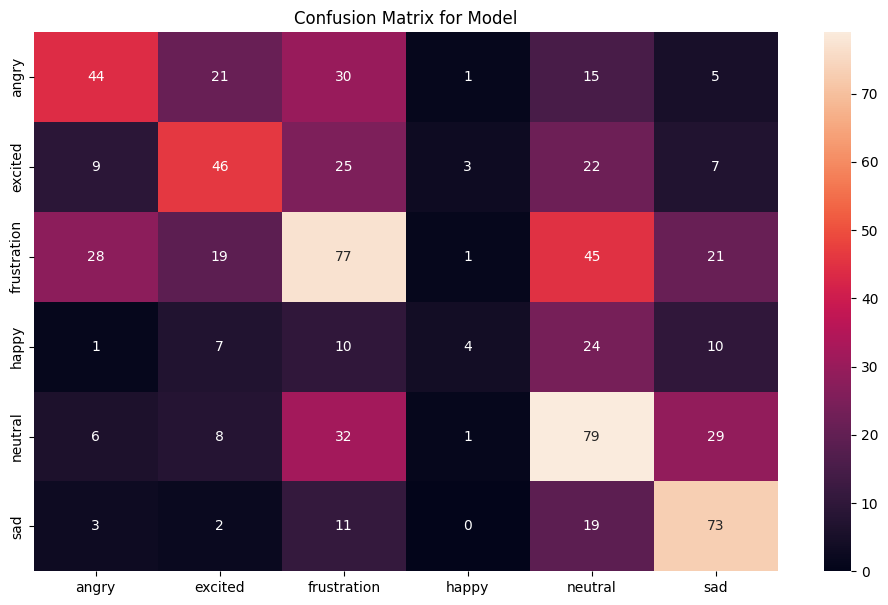

In [72]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_check, y_pred)
cm = pd.DataFrame(
    conf, index=[i for i in emotion_names], columns=[i for i in emotion_names]
)

plt.figure(figsize=(12, 7))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_title(f'Confusion Matrix for Model')
plt.show()


In [73]:
from sklearn.metrics import classification_report

print(f'Model Confusion Matrix\n', classification_report(y_check, y_pred, target_names=emotion_names))


Model Confusion Matrix
               precision    recall  f1-score   support

       angry       0.48      0.38      0.43       116
     excited       0.45      0.41      0.43       112
 frustration       0.42      0.40      0.41       191
       happy       0.40      0.07      0.12        56
     neutral       0.39      0.51      0.44       155
         sad       0.50      0.68      0.58       108

    accuracy                           0.44       738
   macro avg       0.44      0.41      0.40       738
weighted avg       0.44      0.44      0.42       738

